In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
    
import os
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from numpy.linalg import pinv
from sys import platform
from xgcm import Grid
from viztool import FormatScalarFormatter, pcolor_center, pcolor_lim

def fxn():
    warnings.warn('deprecated', DeprecationWarning)

In [2]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

In [4]:
cname = 'd11_M003_Ri040_em01_Q001_W000_D000_St0'
ds = xr.open_dataset(data_dir+cname+'_finescale_fluxes.nc')
ds.close()

# α_used     = ds.α[ds.tracer_used]
# α_reserved = ds.α[~ds.tracer_used]
ds['timeTf'] = ds.time/np.timedelta64(int(np.around(2*np.pi/1e-4)), 's')
ds['day'] = ds.time/np.timedelta64(1, 'D')
ds['xC'] = ds.xC/1e3
ds['yC'] = ds.yC/1e3
ds

<xarray.Dataset> Size: 60GB
Dimensions:   (i: 3, time: 2, zC: 64, yC: 1000, xC: 2000, α: 7, β: 1, j: 3,
               zF: 65, yF: 1000, xF: 2000)
Coordinates:
  * zC        (zC) float32 256B -142.8 -130.4 -121.2 ... -4.246 -2.548 -0.8492
  * xC        (xC) float32 8kB -3.998 -3.994 -3.99 -3.986 ... 3.99 3.994 3.998
  * yC        (yC) float32 4kB 0.002 0.006 0.01 0.014 ... 3.986 3.99 3.994 3.998
  * time      (time) timedelta64[ns] 16B 7 days 7 days 12:00:00
  * zF        (zF) float32 260B -150.0 -135.6 -125.1 ... -3.397 -1.698 0.0
  * yF        (yF) float32 4kB 0.0 4.0 8.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF        (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * i         (i) int64 24B 1 2 3
  * α         (α) int64 56B 1 2 3 4 5 6 7
  * β         (β) <U6 24B 'active'
  * j         (j) int64 24B 1 2 3
Data variables:
    ⟨uᵢ⟩      (i, time, zC, yC, xC) float32 3GB ...
    ⟨cᵅ⟩      (α, time, zC, yC, xC) float32 7GB ...
    ⟨bᵝ⟩      (β, time, zC, yC, xC) float32 1GB ...
    ⟨uᵢᵗcᵅᵗ⟩  (time, zC, i, α, yC, xC) float32 22GB ...
    ⟨uᵢᵗbᵝᵗ⟩  (time, zC, i, β, yC, xC) float32 3GB ...
    ∇ⱼ⟨cᵅ⟩    (j, α, time, zC, yC, xC) float32 22GB ...
    ∇ⱼ⟨bᵝ⟩    (j, β, time, zC, yC, xC) float32 3GB ...
    timeTf    (time) float64 16B 9.626 10.31
    day       (time) float64 16B 7.0 7.5
Attributes: (12/73)
    Ly:                     4000.0
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ϵv:                     0.0018
    Hm:                     60.0
    ...                     ...
    τ₀ʸ:                    0.0
    tracer_reset_interval:  1
    Ny:                     1000
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   40.0
    σ_wind:                 0

In [ ]:
plt.close()
_,ax = plt.subplots(3,3, figsize=(8,5), constrained_layout=True, sharex=True, sharey=True)
itime = slice(24*3*2-1, 24*3*2)
trag = 1
trab = 4
trm = 7

mldm = ds['mld'].isel(time=itime).mean(['yC', 'time'])
bm = ds['⟨bᵝ⟩ₐ'].isel(time=itime).sel(β='active').mean('time')
blines = np.arange(1.9, 3.3, 0.06)*1e-4

wcm = np.abs(ds['⟨wᵗcᵅᵗ⟩ₐ']).isel(time=itime).sel(α=trag).mean('time').max(['xC', 'zC'])
_,mag1 = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), ax[0,0])
ax[0,0].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[0,0].plot(ds.xC, -mldm, 'k', lw=2)
ax[0,0].contour(ds.xC, ds.zC, ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [0.1*wcm], colors='k', linewidths=0.8)
ax[0,0].contour(ds.xC, ds.zC, ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [-0.1*wcm], colors='k', linestyles='--', linewidths=0.8)
ax[0,0].set_title(rf"$\overline{{w^t c_{{{trag}}}^t}}$")
pcm,_ = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trag).mean(['yC', 'time']), ax[0,1], sym_mag=mag1)
ax[0,1].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[0,1].plot(ds.xC, -mldm, 'k', lw=2)
ax[0,1].contour(ds.xC, ds.zC, ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [0.1*wcm], colors='k', linewidths=0.8)
ax[0,1].contour(ds.xC, ds.zC, ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [-0.1*wcm], colors='k', linestyles='--', linewidths=0.8)
ax[0,1].set_title(rf"new $\overline{{w^t c_{{{trag}}}^t}}|_r$")
pcolor_center(ds1['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trag).mean(['yC', 'time']), ax[0,2], sym_mag=mag1)
ax[0,2].contour(ds1.xC, ds1.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[0,2].plot(ds1.xC, -mldm, 'k', lw=2)
ax[0,2].contour(ds1.xC, ds1.zC, ds1['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [0.1*wcm], colors='k', linewidths=0.8)
ax[0,2].contour(ds1.xC, ds1.zC, ds1['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trag).mean('time'), [-0.1*wcm], colors='k', linestyles='--', linewidths=0.8)
ax[0,2].set_title(rf"old $\overline{{w^t c_{{{trag}}}^t}}|_r$")
cbar = plt.colorbar(pcm, ax=ax[0,:])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((4,0))


wcm = np.abs(ds['⟨wᵗcᵅᵗ⟩ₐ']).isel(time=itime).sel(α=trab).mean('time').max(['xC', 'zC'])
_,mag1 = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trab).mean('time'), ax[1,0])
ax[1,0].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[1,0].plot(ds.xC, -mldm, 'k', lw=2)
ax[1,0].set_title(rf"$\overline{{w^t c_{{{trab}}}^t}}$")
pcm,_ = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trab).mean(['yC', 'time']), ax[1,1], sym_mag=mag1)
ax[1,1].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[1,1].plot(ds.xC, -mldm, 'k', lw=2)
ax[1,1].set_title(rf"new $\overline{{w^t c_{{{trab}}}^t}}|_r$")
pcolor_center(ds1['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trab).mean(['yC', 'time']), ax[1,2], sym_mag=mag1)
ax[1,2].contour(ds1.xC, ds1.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[1,2].plot(ds1.xC, -mldm, 'k', lw=2)
ax[1,2].set_title(rf"old $\overline{{w^t c_{{{trab}}}^t}}|_r$")
cbar = plt.colorbar(pcm, ax=ax[1,:])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((4,0))


wcm = np.abs(ds['⟨wᵗcᵅᵗ⟩ₐ']).isel(time=itime).sel(α=trm).mean('time').max(['xC', 'zC'])
_,mag1 = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ₐ'].isel(time=itime).sel(α=trm).mean('time'), ax[2,0])
ax[2,0].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[2,0].plot(ds.xC, -mldm, 'k', lw=2)
ax[2,0].set_title(rf"$\overline{{w^t c_{{{trm}}}^t}}$")
pcm,_ = pcolor_center(ds['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trm).mean(['yC', 'time']), ax[2,1], sym_mag=mag1)
ax[2,1].contour(ds.xC, ds.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[2,1].plot(ds.xC, -mldm, 'k', lw=2)
ax[2,1].set_title(rf"new $\overline{{w^t c_{{{trm}}}^t}}|_r$")
pcolor_center(ds1['⟨wᵗcᵅᵗ⟩ᵣ'].isel(time=itime).sel(α=trm).mean(['yC', 'time']), ax[2,2], sym_mag=mag1)
ax[2,2].contour(ds1.xC, ds1.zC, bm, levels=blines, colors='gray', linewidths=0.5)
ax[2,2].plot(ds1.xC, -mldm, 'k', lw=2)
ax[2,2].set_title(rf"old $\overline{{w^t c_{{{trm}}}^t}}|_r$")
cbar = plt.colorbar(pcm, ax=ax[2,:])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((4,0))
ax[1,0].set_ylim(-100, -40);

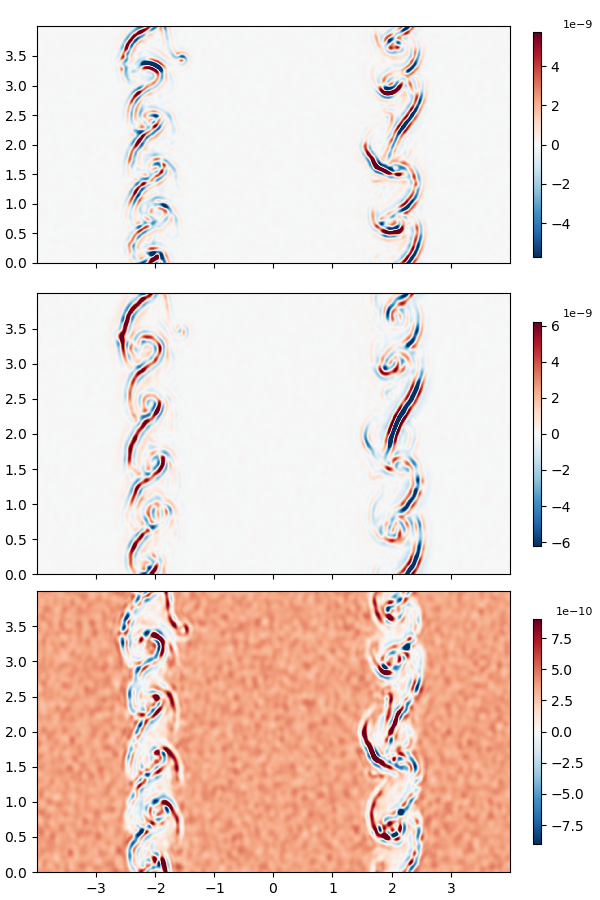

In [15]:
plt.close()
_,ax = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True, constrained_layout=True)

pcm,_ = pcolor_center(ds['⟨uᵢᵗbᵝᵗ⟩'].isel(β=0, time=0, zC=58).sel(i=1), ax[0])
cbar = plt.colorbar(pcm, ax=ax[0], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

pcm,_ = pcolor_center(ds['⟨uᵢᵗbᵝᵗ⟩'].isel(β=0, time=0, zC=58).sel(i=2), ax[1])
cbar = plt.colorbar(pcm, ax=ax[1], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

pcm,_ = pcolor_center(ds['⟨uᵢᵗbᵝᵗ⟩'].isel(β=0, time=0, zC=58).sel(i=3), ax[2])
cbar = plt.colorbar(pcm, ax=ax[2], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

ax[0].set_aspect(1);

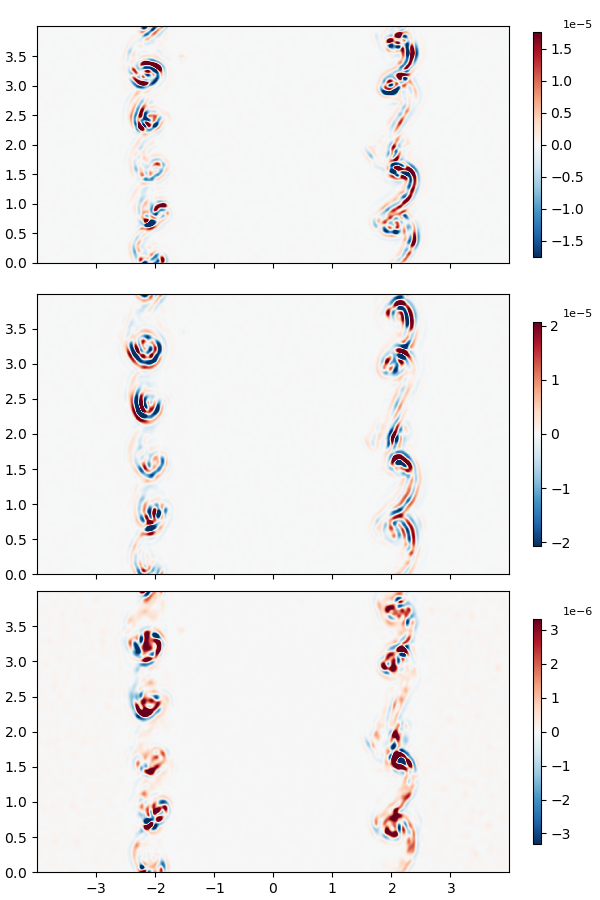

In [16]:
plt.close()
_,ax = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True, constrained_layout=True)

pcm,_ = pcolor_center(ds['⟨uᵢᵗcᵅᵗ⟩'].isel(time=0, zC=58).sel(α=7, i=1), ax[0])
cbar = plt.colorbar(pcm, ax=ax[0], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

pcm,_ = pcolor_center(ds['⟨uᵢᵗcᵅᵗ⟩'].isel(time=0, zC=58).sel(α=7, i=2), ax[1])
cbar = plt.colorbar(pcm, ax=ax[1], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

pcm,_ = pcolor_center(ds['⟨uᵢᵗcᵅᵗ⟩'].isel(time=0, zC=58).sel(α=7, i=3), ax[2])
cbar = plt.colorbar(pcm, ax=ax[2], aspect=30, shrink=0.8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(8)
cbar.ax.yaxis.get_offset_text().set_position((8,0))

ax[0].set_aspect(1);